In [9]:
# basic packages
import pandas as pd
import numpy as np
from datetime import datetime as dt

# bigquery connection
from google.cloud import bigquery
from google.oauth2 import service_account

# dash 
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# plotly
from plotly import graph_objs as go
from plotly.graph_objs import *

In [18]:
file = './My First Project-5abe6994fdf1.json'
credentials = service_account.Credentials.from_service_account_file(file)
project_id = 'keen-bucksaw-273300'
client = bigquery.Client(credentials= credentials,project=project_id)

# Plotly mapbox public token
mapbox_access_token = "pk.eyJ1IjoicGxvdGx5bWFwYm94IiwiYSI6ImNqdnBvNDMyaTAxYzkzeW5ubWdpZ2VjbmMifQ.TXcBE-xg9BFdV2ocecc_7g"

In [1]:
# Dictionary of important locations in New York
list_of_locations = {
    "Madison Square Garden": {"lat": 40.7505, "lon": -73.9934},
    "Yankee Stadium": {"lat": 40.8296, "lon": -73.9262},
    "Empire State Building": {"lat": 40.7484, "lon": -73.9857},
    "New York Stock Exchange": {"lat": 40.7069, "lon": -74.0113},
    "JFK Airport": {"lat": 40.644987, "lon": -73.785607},
    "Grand Central Station": {"lat": 40.7527, "lon": -73.9772},
    "Times Square": {"lat": 40.7589, "lon": -73.9851},
    "Columbia University": {"lat": 40.8075, "lon": -73.9626},
    "United Nations HQ": {"lat": 40.7489, "lon": -73.9680},
}

In [14]:
# Initialize data frame
df1 = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data1.csv",
    dtype=object,
)
df2 = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data2.csv",
    dtype=object,
)
df3 = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data3.csv",
    dtype=object,
)
df = pd.concat([df1, df2, df3], axis=0)
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%Y-%m-%d %H:%M")
df.index = df["Date/Time"]
df.drop("Date/Time", 1, inplace=True)
totalList = []
for month in df.groupby(df.index.month):
    dailyList = []
    for day in month[1].groupby(month[1].index.day):
        dailyList.append(day[1])
    totalList.append(dailyList)
totalList = np.array(totalList)

In [10]:
# Gets the amount of days in the specified month
# Index represents month (0 is April, 1 is May, ... etc.)
daysInMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Get index for the specified month in the dataframe
monthIndex = pd.Index(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"])

In [11]:
# Get the amount of rides per hour based on the time selected
# This also higlights the color of the histogram bars based on
# if the hours are selected
def get_selection(month, day, selection):
    xVal = []
    yVal = []
    xSelected = []
    colorVal = [
        "#F4EC15",
        "#DAF017",
        "#BBEC19",
        "#9DE81B",
        "#80E41D",
        "#66E01F",
        "#4CDC20",
        "#34D822",
        "#24D249",
        "#25D042",
        "#26CC58",
        "#28C86D",
        "#29C481",
        "#2AC093",
        "#2BBCA4",
        "#2BB5B8",
        "#2C99B4",
        "#2D7EB0",
        "#2D65AC",
        "#2E4EA4",
        "#2E38A4",
        "#3B2FA0",
        "#4E2F9C",
        "#603099",
    ]

    # Put selected times into a list of numbers xSelected
    xSelected.extend([int(x) for x in selection])

    for i in range(24):
        # If bar is selected then color it white
        if i in xSelected and len(xSelected) < 24:
            colorVal[i] = "#FFFFFF"
        xVal.append(i)
        # Get the number of rides at a particular time
        yVal.append(len(totalList[month][day][totalList[month][day].index.hour == i]))
    return [np.array(xVal), np.array(yVal), np.array(colorVal)]

In [12]:
# Get the Coordinates of the chosen months, dates and times
def getLatLonColor(selectedData, month, day):
    listCoords = totalList[month][day]

    # No times selected, output all times for chosen month and date
    if selectedData is None or len(selectedData) is 0:
        return listCoords
    listStr = "listCoords["
    for time in selectedData:
        if selectedData.index(time) is not len(selectedData) - 1:
            listStr += "(totalList[month][day].index.hour==" + str(int(time)) + ") | "
        else:
            listStr += "(totalList[month][day].index.hour==" + str(int(time)) + ")]"
    return eval(listStr)

In [16]:
# chart info

# for testing
datePicked = '2013-01-01' # selecting date
selectedData = '1' # selecting hour
selectedLocation = False #'Empire State Building' selecting location

zoom = 12.0
latInitial = 40.7272
lonInitial = -73.991251
bearing = 0

if selectedLocation:
    zoom = 15.0
    latInitial = list_of_locations[selectedLocation]["lat"]
    lonInitial = list_of_locations[selectedLocation]["lon"]

date_picked = dt.strptime(datePicked, "%Y-%m-%d")
monthPicked = date_picked.month - 4
dayPicked = date_picked.day - 1
listCoords = getLatLonColor(selectedData, monthPicked, dayPicked)

In [19]:
fig = go.Figure(
    data = [
#         Data for all rides based on date and time
        Scattermapbox(
            lat = listCoords['Lat'],
            lon = listCoords['Lon'],
            mode = 'markers',
            marker = dict(
                showscale = True,
                color = np.append(np.insert(listCoords.index.hour, 0 , 0), 23),
                opacity = 0.5,
                size = 5,
                colorscale = [                
                    [0, "#F4EC15"],
                    [0.04167, "#DAF017"],
                    [0.0833, "#BBEC19"],
                    [0.125, "#9DE81B"],
                    [0.1667, "#80E41D"],
                    [0.2083, "#66E01F"],
                    [0.25, "#4CDC20"],
                    [0.292, "#34D822"],
                    [0.333, "#24D249"],
                    [0.375, "#25D042"],
                    [0.4167, "#26CC58"],
                    [0.4583, "#28C86D"],
                    [0.50, "#29C481"],
                    [0.54167, "#2AC093"],
                    [0.5833, "#2BBCA4"],
                    [1.0, "#613099"],
                ],
                colorbar = dict(
                        title="Time of<br>Day",
                        x=0.93,
                        xpad=0,
                        nticks=24,
                        tickfont=dict(color="#d8d8d8"),
                        titlefont=dict(color="#d8d8d8"),
                        thicknessmode="pixels",                    
                ),
            ),
        ),
        # Plot of important locations on the map
        Scattermapbox(
            lat=[list_of_locations[i]["lat"] for i in list_of_locations],
            lon=[list_of_locations[i]["lon"] for i in list_of_locations],
            mode="markers",
            hoverinfo="text",
            text=[i for i in list_of_locations],
            marker=dict(size=8, color="#ffa0a0"),
        ),        
    ],
    layout=Layout(
        autosize=True,
        margin=go.layout.Margin(l=0, r=35, t=0, b=0),
        showlegend=False,
        mapbox=dict(
            accesstoken=mapbox_access_token,
            center=dict(lat=latInitial, lon=lonInitial),  # 40.7272  # -73.991251
            style="dark",
            bearing=bearing,
            zoom=zoom,
        ),
        updatemenus=[
            dict(
                buttons=(
                    [
                        dict(
                            args=[
                                {
                                    "mapbox.zoom": 12,
                                    "mapbox.center.lon": "-73.991251",
                                    "mapbox.center.lat": "40.7272",
                                    "mapbox.bearing": 0,
                                    "mapbox.style": "dark",
                                }
                            ],
                            label="Reset Zoom",
                            method="relayout",
                        )
                    ]
                ),
                direction="left",
                pad={"r": 0, "t": 0, "b": 0, "l": 0},
                showactive=False,
                type="buttons",
                x=0.45,
                y=0.02,
                xanchor="left",
                yanchor="bottom",
                bgcolor="#323130",
                borderwidth=1,
                bordercolor="#6d6d6d",
                font=dict(color="#FFFFFF"),
            )
        ],
    ),
)

In [25]:
listCoords.shape[0]

111

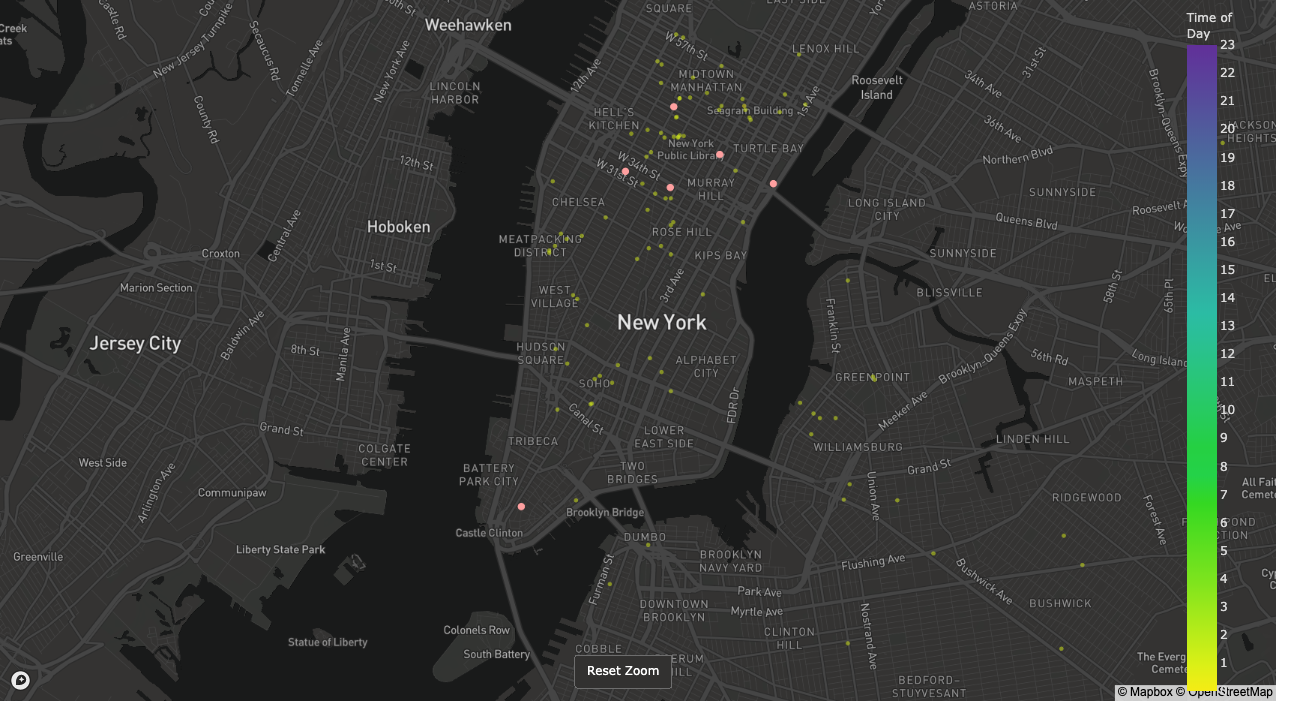

In [22]:
fig.update_layout(
    autosize = False,
    width = 1100,
    height = 700
)

fig.show()